**Author:**
* Carlos Arias Cortina

# Final Project: *Horse Colic*

**Project Description**

This project is about exploring the UC Irvine horse colic dataset and using it to find a real-world application in horse health and care.

**Project Goals**

* Look for characteristics most associated with cases where colic has required surgical intervention to be treated.
* Look for characteristics of the horse's condition that are associated with outcomes ("alive", "dead" or "euthanized").



**Description of the dataset**

The dataset used for this research is the UC Irvine horse colic dataset. The data contains a variety of characteristics, both categorical and numerical, and includes continuous and discrete numerical values. Each row is a distinct case of colic in a horse, and outcomes (whether the horse lived, died, or was euthanized, as well as whether the colic required surgery) are also included. The data were obtained from UC Irvine's machine learning dataset archives.

Link to download the dataset: https://www.kaggle.com/datasets/uciml/horse-colic?resource=download

# Libraries

In [ ]:
# Dataframes y visualización
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

# Preprocesamiento
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.utils.sparsefuncs import min_max_axis

# Modelado (en caso de)
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, auc, roc_auc_score, accuracy_score
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier # <----- CLASIFICACION
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV # Hiper-parameter tuning

from sklearn.metrics import mean_absolute_error, mean_squared_error # <----- EVALUACION
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay

from sklearn.neural_network import MLPClassifier

import warnings
# Resultados reproducibles
np.random.seed(42)

# Ignorar warnings
warnings.filterwarnings('ignore')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
from subprocess import call
from sklearn.tree import DecisionTreeClassifier, export_graphviz

# Development

### Initialize dataframe

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Instalar archivo al conectar el entorno de ejecución porque las direcciones de drive son diferentes para todos
horse_data = pd.read_csv("/content/drive/MyDrive/Especialidad/Aprendizaje Automático/Proyecto Final/horse.csv")
horse_data.head()

,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,...,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,outcome,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data
0,no,adult,530101,38.5,66.0,28.0,cool,reduced,NaN,more_3_sec,...,45.0,8.4,NaN,NaN,died,no,11300,0,0,no
1,yes,adult,534817,39.2,88.0,20.0,NaN,NaN,pale_cyanotic,less_3_sec,...,50.0,85.0,cloudy,2.0,euthanized,no,2208,0,0,no
2,no,adult,530334,38.3,40.0,24.0,normal,normal,pale_pink,less_3_sec,...,33.0,6.7,NaN,NaN,lived,no,0,0,0,yes
3,yes,young,5290409,39.1,164.0,84.0,cold,normal,dark_cyanotic,more_3_sec,...,48.0,7.2,serosanguious,5.3,died,yes,2208,0,0,yes
4,no,adult,530255,37.3,104.0,35.0,NaN,NaN,dark_cyanotic,more_3_sec,...,74.0,7.4,NaN,NaN,died,no,4300,0,0,no


In [ ]:
horse_data.shape

(299, 28)

Tenemos un set de datos de 28 atributos con 299 registros

### Data Cleaning

In [ ]:
# Eliminar las columnas innecesarias
horse_data_cleaned = horse_data.drop(['lesion_1', 'lesion_2', 'lesion_3',
                                      'nasogastric_reflux_ph', 'abdomo_appearance',
                                      'abdomo_protein', 'hospital_number', 'cp_data'], axis=1)

# Eliminar las filas sin información de resultados
horse_data_cleaned = horse_data_cleaned[~horse_data_cleaned['surgery'].isnull() |
                                        ~horse_data_cleaned['outcome'].isnull() |
                                        ~horse_data_cleaned['surgical_lesion'].isnull()]

# Rellenar los valores numéricos que faltan
numeric_cols = ['rectal_temp', 'pulse', 'respiratory_rate', 'packed_cell_volume', 'total_protein']

for col in numeric_cols:
    horse_data_cleaned[col].fillna(horse_data_cleaned[col].mean(), inplace = True)

# columnas categóricas
categoric_cols = ['age', 'temp_of_extremities', 'peripheral_pulse', 'mucous_membrane',
                  'capillary_refill_time', 'peristalsis', 'abdominal_distention',
                  'nasogastric_tube', 'nasogastric_reflux', 'rectal_exam_feces', 'abdomen',
                  'pain']

for col in categoric_cols:
    horse_data_cleaned_dummies = pd.concat([horse_data_cleaned,
                                    pd.get_dummies(horse_data_cleaned[col],
                                                   prefix=col)], axis=1).drop([col],axis=1)

# Separar las columnas relacionadas con los resultados de las características
horse_data_outcomes = horse_data_cleaned_dummies[['surgery', 'outcome', 'surgical_lesion']]
horse_data_features = horse_data_cleaned_dummies.drop(['surgery', 'outcome', 'surgical_lesion'], axis=1)

# Determinar los nombres de las columnas para las características categóricas
categoric_features = [c for c in horse_data_features.columns.values if '_'.join(c.split('_')[:-1]) in categoric_cols]

In [ ]:
horse_data_cleaned.shape # 20 atributos y 299 registros

(299, 20)

In [ ]:
# Buscar datos faltantes
horse_data_cleaned.isnull().sum()

surgery                    0
age                        0
rectal_temp                0
pulse                      0
respiratory_rate           0
temp_of_extremities       56
peripheral_pulse          69
mucous_membrane           47
capillary_refill_time     32
pain                      55
peristalsis               44
abdominal_distention      56
nasogastric_tube         104
nasogastric_reflux       106
rectal_exam_feces        102
abdomen                  118
packed_cell_volume         0
total_protein              0
outcome                    0
surgical_lesion            0
dtype: int64

In [ ]:
horse_q1_features = horse_data_features[numeric_cols + categoric_features]
horse_q1_outcomes = pd.Series((horse_data_outcomes['surgery'] == 'yes')
                              | (horse_data_outcomes['surgical_lesion'] == 'yes'))

In [ ]:
horse_q2_features = horse_data_features[numeric_cols + categoric_features]
horse_q2_outcomes = pd.Series(horse_data_outcomes['outcome'] == 'lived')

### Exploration

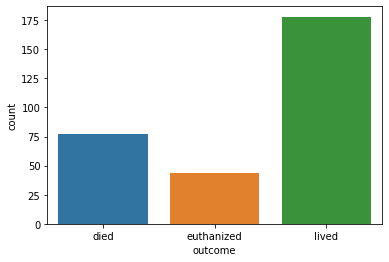

In [ ]:
# Cuántos dentro del dataset cuantos caballos se murieron, sacrificados y vivieron
sns.countplot(x='outcome',data=horse_data_cleaned)
plt.show() # La mayor parte de los registros son de caballos que vivieron

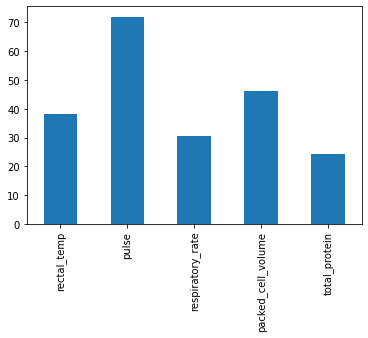

In [ ]:
# Visualizar los promedios de los datos
horse_data_cleaned.describe().loc['mean'].plot(kind='bar')
plt.show()

Los caballos con un pulso alto suelen morirse y ser sacrificados.

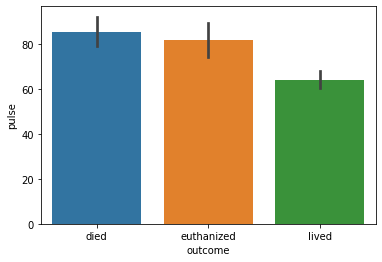

In [ ]:
sns.barplot(x='outcome',y='pulse',data=horse_data_cleaned)
plt.show()

Los caballos con altos niveles de proteina suelen ser sacrificados.

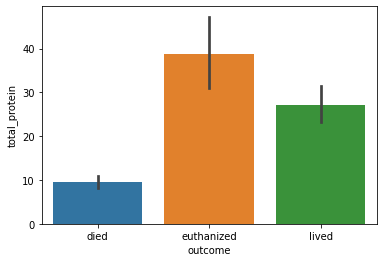

In [ ]:
sns.barplot(x='outcome',y='total_protein',data=horse_data_cleaned)
plt.show()

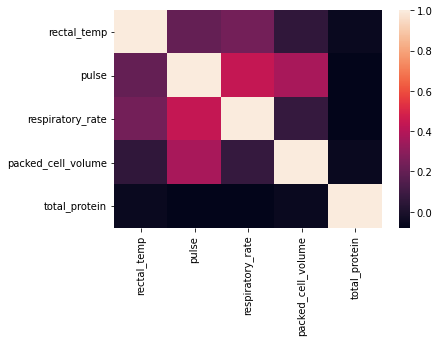

In [ ]:
# Visualizar correlaciones entre diferentes variables
sns.heatmap(horse_data_cleaned.corr())
plt.show()

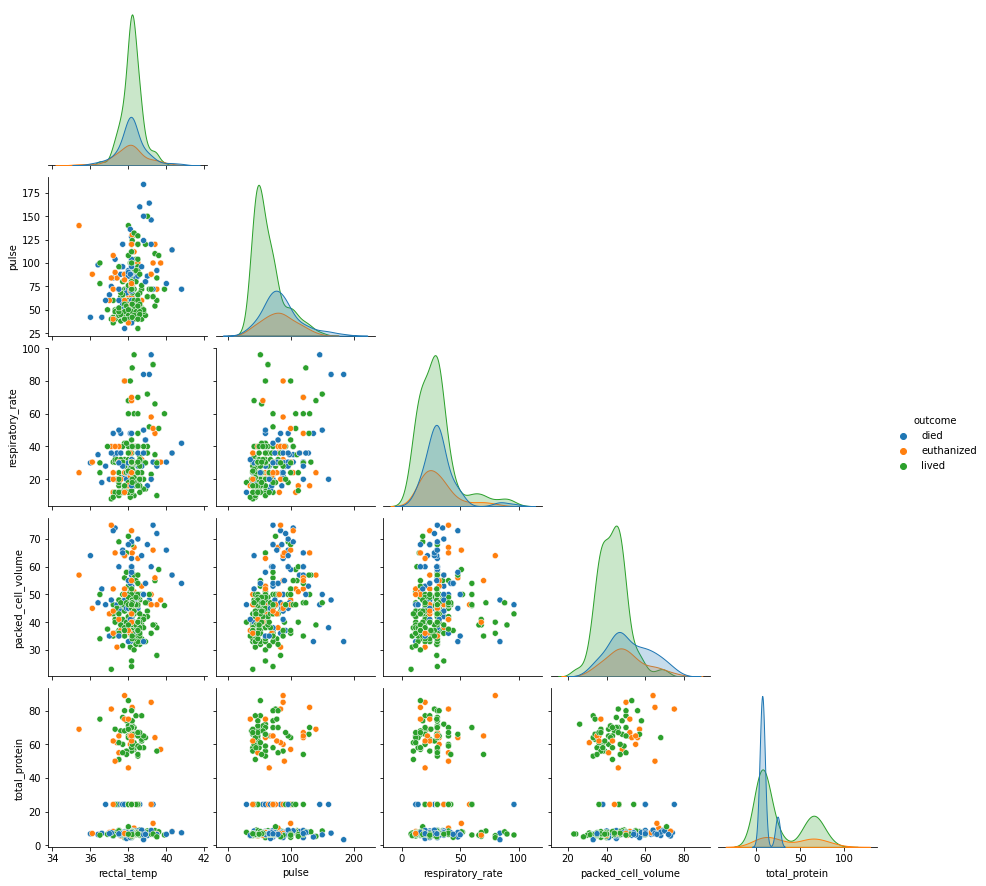

In [ ]:
sns.pairplot(data =horse_data_cleaned, hue='outcome',corner=True)
plt.show()

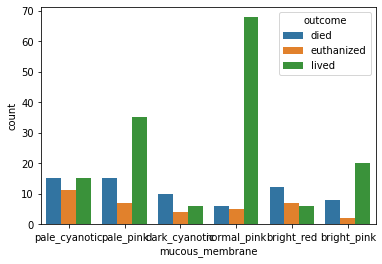

In [ ]:
sns.countplot(x='mucous_membrane',data=horse_data_cleaned, hue='outcome')
plt.show()

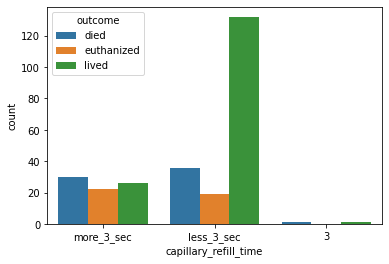

In [ ]:
sns.countplot(x='capillary_refill_time',data=horse_data_cleaned, hue='outcome')
plt.show()

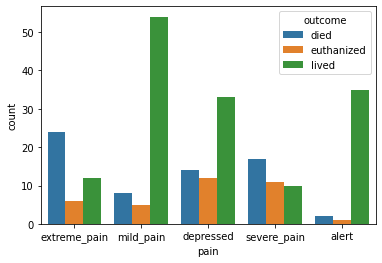

In [ ]:
sns.countplot(x='pain',data=horse_data_cleaned, hue='outcome')
plt.show()

### Data Standardization

In [ ]:
horse_data_final = horse_data_cleaned[['rectal_temp', 'pulse', 'respiratory_rate', 'packed_cell_volume', 'total_protein', 'outcome']]

(299, 7)

In [ ]:
horse_data_num = horse_data_final.drop(['outcome'],axis=1)
x =horse_data_num.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_scaled = pd.DataFrame(x_scaled,columns= horse_data_num.keys())
df_scaled.describe()

,rectal_temp,pulse,respiratory_rate,packed_cell_volume,total_protein
count,299.000000,299.000000,299.000000,299.000000,299.000000
mean,0.512707,0.272727,0.255234,0.448219,0.244743
std,0.121432,0.178367,0.180159,0.190691,0.301104
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.462963,0.120130,0.136364,0.307692,0.038506
50%,0.512707,0.246753,0.250000,0.442308,0.051342
75%,0.574074,0.376623,0.301136,0.519231,0.568261
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
df_scaled.head()

,rectal_temp,pulse,respiratory_rate,packed_cell_volume,total_protein
0,0.574074,0.233766,0.227273,0.423077,0.059510
1,0.703704,0.376623,0.136364,0.519231,0.953326
2,0.537037,0.064935,0.181818,0.192308,0.039673
3,0.685185,0.870130,0.863636,0.480769,0.045508
4,0.351852,0.480519,0.306818,0.980769,0.047841


In [ ]:
df_scaled.shape

(299, 5)

### Model Selection

In [ ]:
X =df_scaled
y = horse_data_final['outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.30)

In [ ]:
# El siguiente código entrena y prueba 5 clasificadores utilizando los parámetros por default.
classification_models = {'Logistic Regression': LogisticRegression(multi_class='ovr', solver='lbfgs'),
                         'Decision Tree': DecisionTreeClassifier(),
                         'KNN': KNeighborsClassifier(),
                         'Random Forest':RandomForestClassifier(n_estimators=100, random_state=2),
                         'K Means': KMeans(n_clusters=5)
                         }

for name, model in classification_models.items():

    print(f'------ {name} ------')

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred) * 100

    print(f'Test accuracy = {accuracy:.2f} %\n')

------ Logistic Regression ------
Test accuracy = 61.11 %

------ Decision Tree ------
Test accuracy = 63.33 %

------ KNN ------
Test accuracy = 65.56 %

------ Random Forest ------
Test accuracy = 65.56 %

------ K Means ------
Test accuracy = 0.00 %



### Desicion Tree

In [ ]:
def plot_tree(estimator, features, class_names, file_name):
    """Display a graphical representation of the decision tree specified in 'estimator' and save .png file"""
    # Exportar como archivo de puntos
    export_graphviz(estimator, out_file=file_name + '.dot',
                    feature_names = features,
                    class_names = class_names,
                    rounded = True, proportion = False,
                    precision = 2, filled = True)

    # Convertir a png
    call(['dot', '-Tpng', file_name + '.dot', '-o', file_name + '.png', '-Gdpi=600'])

    # Visualización en python
    plt.figure(figsize = (14, 18))
    plt.imshow(plt.imread(file_name + '.png'))
    plt.axis('off')
    plt.show()

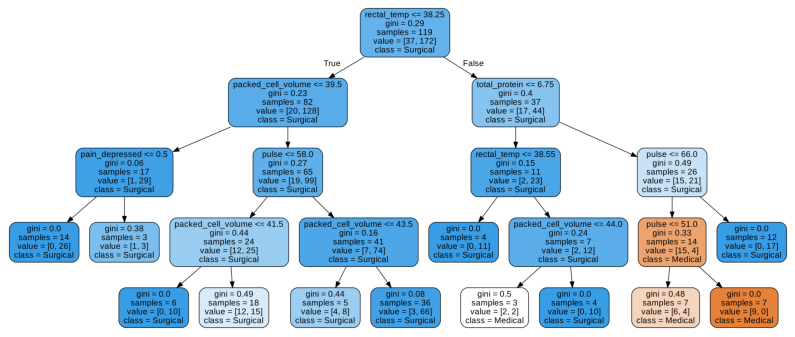

In [ ]:
# Quirúrgico vs Medicina
estimator = model.estimators_[5]

features = horse_q1_features.columns.values
class_names = ['Medical', 'Surgical']
file_name = 'tree'

plot_tree(estimator, features, class_names, file_name)

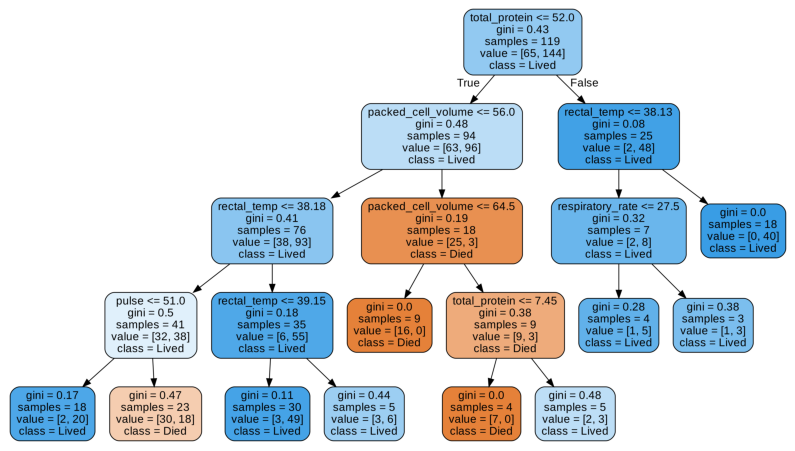

In [ ]:
# Vivo vs Muerto
estimator2 = model2.estimators_[5]

features2 = horse_q2_features.columns.values
class_names2 = ['Died', 'Lived']
file_name2 = 'tree2'

plot_tree(estimator2, features2, class_names2, file_name2)

### Random Forest

In [ ]:
x =df_scaled
y = horse_data_final['outcome']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.3, random_state= 0)

In [ ]:
print('Shape for training data', x_train.shape, y_train.shape)
print('Shape for testing data', x_test.shape, y_test.shape)

Shape for training data (209, 5) (209,)
Shape for testing data (90, 5) (90,)


In [ ]:
# Normalización
scaler = MinMaxScaler()
X_train = scaler.fit_transform(x_train)
X_test= scaler.transform(x_test)

In [ ]:
model = RandomForestClassifier(n_estimators=100,random_state=6)
model.fit(x_train, y_train)
predicted=model.predict(x_test)
conf = confusion_matrix(y_test, predicted)

print("The accuracy of Random Forest is : {:.2f} %".format(accuracy_score(y_test, predicted)*100))
print('Accuracy of Random Forest classifier on training set: {:.2f}' .format(model.score(x_train, y_train)))
print('Accuracy of Random Forest classifier on test set: {:.2f}'.format(model.score(x_test, y_test)))

The accuracy of Random Forest is : 66.67 %
Accuracy of Random Forest classifier on training set: 0.99
Accuracy of Random Forest classifier on test set: 0.67


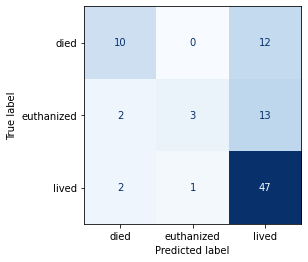

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test,
                                        predicted,
                                        labels=best_model.classes_,
                                        cmap='Blues',
                                        colorbar=False)
plt.show()

# Conclusions



---

**Conclusions**

This project helped me to reinforce my knowledge about automatic learning and I was also able to measure the accuracy of the models to choose the most accurate one, which in my case was Random Forest with 66.67% accuracy.

I was also able to notice that by having a larger number of horses with the live status, the model had a harder time predicting the dead and slaughtered statuses. The "total protein" variable has been the best predictor of the state of the horses, since the higher it is, the higher the level of dehydration of the horse and note that horses that tend to die, usually have high levels of dehydration.

Finally, we conclude that colic is a frightening situation for any horse owner or professional. The more information we have about colic cases, the more knowledge we will have to help horses.